In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 1.26.4
Pandas version 2.2.3


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification/train'
)

In [4]:
len(dataset)

7624

4


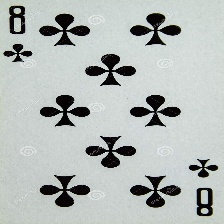

In [5]:
image, label = dataset[608]
print(label)
image

In [6]:
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = { v: k for k, v in ImageFolder(data_dir).class_to_idx.items() }
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingCardDataset(data_dir, transform)

In [8]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [9]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in dataloader:
    break

In [11]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [12]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [13]:
model = SimpleCardClassifier(num_classes=53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [14]:
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [15]:
model(images)

tensor([[ 0.3202, -0.3403,  0.2096,  ..., -0.2390, -0.1141,  0.3838],
        [ 0.0156, -0.1257, -0.5271,  ...,  0.3782,  0.3702, -0.1627],
        [ 0.0251, -0.3735,  0.4815,  ...,  0.0190,  0.3509,  0.1652],
        ...,
        [ 0.3559,  0.2861,  0.1409,  ...,  0.4993, -0.3592, -0.2300],
        [ 0.0145,  0.0631,  0.5542,  ..., -0.0284,  0.1547,  0.3910],
        [-0.0281, -0.3355, -0.3726,  ..., -0.2956,  0.0742,  0.1419]],
       grad_fn=<AddmmBackward0>)